## Final Notebook - Hotel Customer Review Analysis

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import wrangle
import unicodedata
from nltk.corpus import stopwords

plt.rc('figure', figsize=(10, 7))
plt.style.use('fivethirtyeight')

### Project Overview:

- As the data science team at Booking.com we analyzed the extensive customer review dataset for our partner hotels in the European region. Using natural language processing, sentiment analysis, and topic modeling we were able to identify key word and key topic drivers of reviewer’s score. Using reviewer’s scores we calculated current Net Promoter Scores for each hotel helping them understand their customer’s opinions so they can implement improvements based on the insight from our review analysis. 


### Project Goals:

- The goal of this project it to provide actionable recommendations to our partner hotels on how to increase their performance ratings based on our analysis of their customer review data.


### Data Acquisition:

- The dataset was collected from kaggle where said data was scraped from Booking.com. This dataset contains 515,738 customer reviews and scoring of 1493 luxury hotels across Europe with positive and negative reviews along with other columns that contain features for exploration. A data dictionary can be found within the README.md.


### Data Wrangling:

- This project required extensive data cleaning and wrangling including:

    - changing the column names to all lower case
    
    - parsing the list of strings in the tags column into separate feature columns
    
    - changing the data type of the timestamp column and engineering additional features containing portions of the overall time stamp
    
    - verifying and updating review word counts
    
    - parsing the address values and creating separate features for country, city, etc.
    
    - dropping unneeded columns
    
    - preparing the text data from NLP including basic clean, removing stopwords, and lemmatizing
    
    - changing the order of the columns within the dataframe 
    
    - cache the wrangled data as a json to reduce processing time during exploration


In [2]:
# Pull in the cleaned and wrangled dataset using the wrangle_hotel function
df = wrangle.wrangle_hotel(use_cache=False)
# Fill coordinate null values with median coordinates corresponding to each city
df = wrangle.fill_coord_nulls(df)
# Show dataframe information
df.info()
# View the first three rows of the dataframe
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 41 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   review_date                                 515738 non-null  datetime64[ns]
 1   month_name                                  515738 non-null  object        
 2   month                                       515738 non-null  int64         
 3   year                                        515738 non-null  int64         
 4   day_name                                    515738 non-null  object        
 5   day                                         515738 non-null  int64         
 6   quarter                                     515738 non-null  int64         
 7   hotel_name                                  515738 non-null  object        
 8   street                                      515738 non-null  object       

,review_date,month_name,month,year,day_name,day,quarter,hotel_name,street,city,...,review_total_positive_word_counts,positive_unique_word_count,pos_lem_sentiment_score,positive_topic,negative_review,negative_clean_review,negative_lemma,positive_review,positive_clean_review,positive_lemma
0,2015-08-04,August,8,2015,Tuesday,4,3,Hilton London Metropole,225 Edgware Road Westminster Borough,London,...,8,6,0.4019,location,First day the swimming pool was not opened th...,first day swimming pool opened therefore could...,first day swimming pool opened therefore could...,The hotel was clean and accessible,hotel clean accessible,hotel clean accessible
1,2015-08-04,August,8,2015,Tuesday,4,3,Hotel Mademoiselle,7 Rue des Petits H tels 10th,Paris,...,7,6,0.7906,location,No Negative,,,very good location breakfast was great,good location breakfast great,good location breakfast great
2,2015-08-04,August,8,2015,Tuesday,4,3,Vienna Marriott Hotel,Parkring 12a 01 Innere Stadt,Vienna,...,7,6,0.7579,hotel,Nothing,,,It was very nice excellent hotel,nice excellent hotel,nice excellent hotel


---

### Exploration - Who are our Customers?

- The initial exploration of the dataset consisted of reviewing the distribution of customers across key groupings including trip type, group type and nights stayed as well as looking at reviewer score distributions and average hotel score distributions

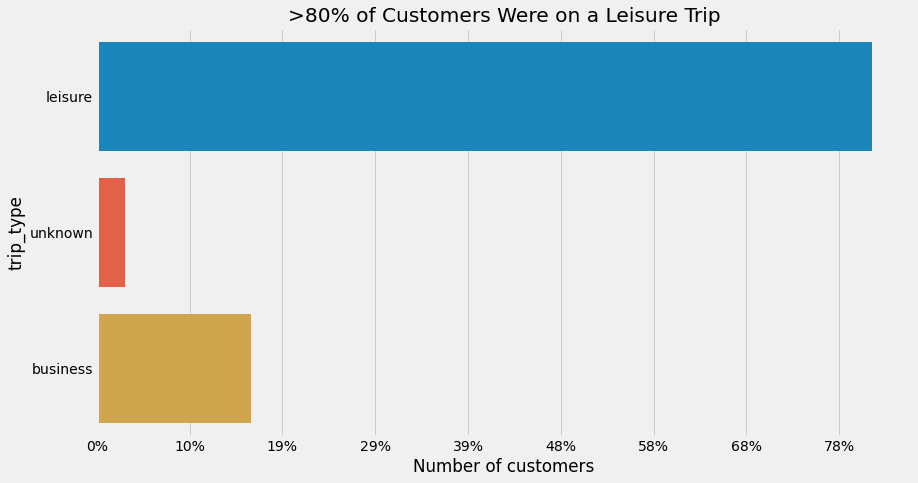

In [3]:
import matplotlib.ticker as mtick
# #visualize the count of customers by trip type

plt.figure(figsize=(13,7))
ax = sns.countplot(y='trip_type', data=df)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(df), decimals=None))

plt.title('>80% of Customers Were on a Leisure Trip')
plt.xlabel('Number of customers')
plt.show()

#### Key Takeaways:

Looking at the chart above 81% of the the customers who gave a review was on a leisure trip. Leaving ~20% of the customers who gave a review to be on a buisness trip or other. Understanding the purpose of the customers stay can help shape the hotel to cater to the needs of the customer who is most likley to give a review. 

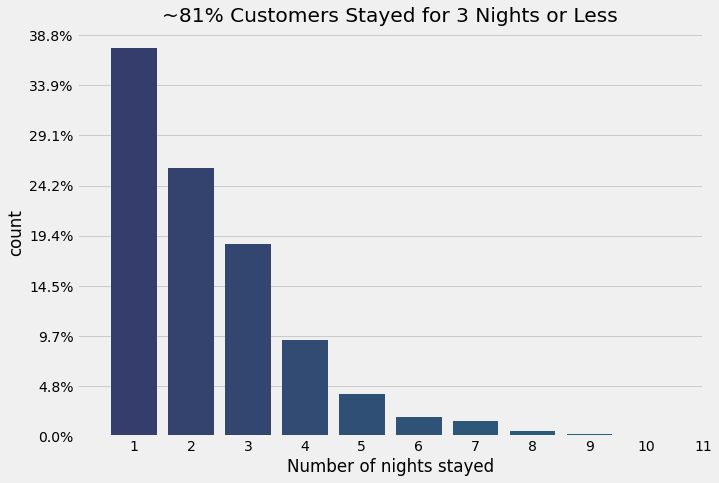

In [4]:
# Fill nulls in nights_stayed and cast as integer type -- should probably add these lines to the wrangle
df.nights_stayed = df.nights_stayed.fillna(1) 
df.nights_stayed = df.nights_stayed.astype('int64')

# Change color of bars
# Visualize the number of customers by number of nights stayed
ax = sns.countplot(x='nights_stayed', data=df, palette='crest_r')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(df), decimals=None))
plt.title('~81% Customers Stayed for 3 Nights or Less')
plt.xlim(-1, 10)
# add labels
plt.xlabel('Number of nights stayed')
# Line of average nights stayed
plt.show()

Key Takeaways:

- 37.5% of customers stayed one night
- 25.9% of customers stayed two nights
- 18.5% of customers stayed three nights
- 9.2% of customers stayed four nights
- 8.9% of customers stayed over four nights


~ 81% of the customers who gave a review stayed at a hotel for less than three nights. Where ~19% of guests stay at a hotel for greater than 3 night. This gives the hotel approximatly three nights to improve the the majority of customers experience for an increase in review score.

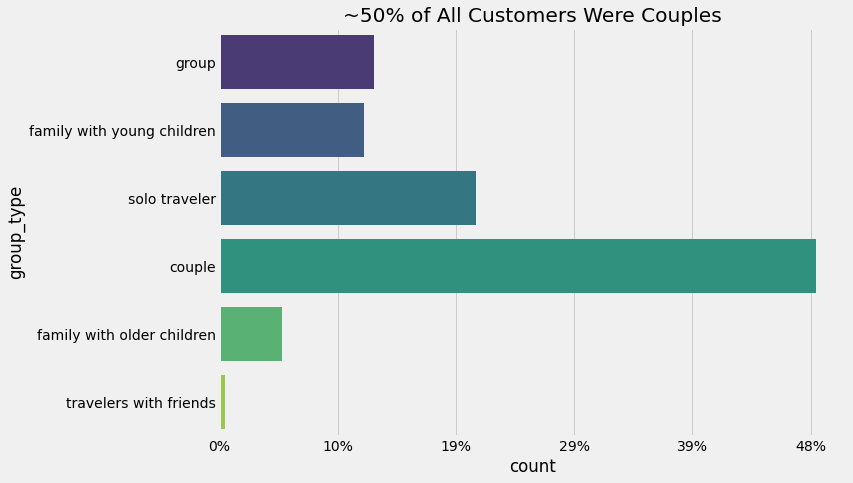

In [5]:
#visualize the number of customers by group type
ax = sns.countplot(y='group_type', data=df, palette='viridis')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(df), decimals=None))
plt.title('~50% of All Customers Were Couples')
plt.show()

Key Takeaways:
- 48.9% of customers who gave a review were a couple.
- 21% of customers who gave a review were solo travelers.
- 12.6% of customers who gave a review were a group.
- 11.8% of customers who gave a review were a family with young children.


The majority of customers who gave a review were couples at 48.9% of all reviews. Followed by solo travelers at 21% of all reviews. 69.9% of all reviews were in parties of two people or less. With ~ 30% of customers who gave a review in a party greater than two people.

---

## Exploration - What is the distribution of reviewer scores?

The distribution of reviewer scores indicates a tendency toward score inflation.

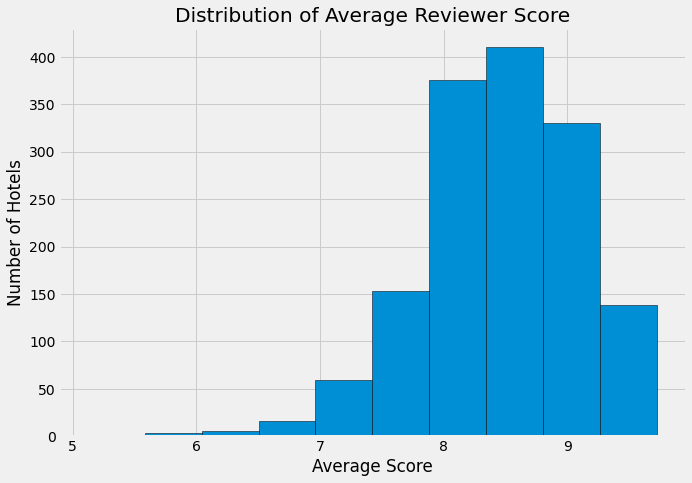

In [6]:
#visualize the distribution of average reviewer score
df.groupby('hotel_name').reviewer_score.mean().plot.hist(ec= 'black')
plt.title('Distribution of Average Reviewer Score')
plt.xlabel('Average Score')
plt.ylabel('Number of Hotels')
# add average score line
plt.show()

Key Takeaways:

The distribution of the reviewer score is skewed to the left. Where the average reviewer score is around 8.4. The lowest reviewer score is 5.12 and the highest reviewer score is 9.73.


In [7]:
#summary stats for reviewer scores
df.reviewer_score.describe()

count    515738.000000
mean          8.395077
std           1.637856
min           2.500000
25%           7.500000
50%           8.800000
75%           9.600000
max          10.000000
Name: reviewer_score, dtype: float64

In [8]:
def hotel_data():
    """Function takes in a Hotel Name 
    and returns the rolling average of the 
    reviewer score and the number of reviews.
    """
    # combine the 'month', 'year', and 'day' columns into a single column called 'date'
    df['date'] = df['month'].astype(str) + '/' + df['day'].astype(str) + '/' + df['year'].astype(str)
    # create datetime with date column
    df['date'] = pd.to_datetime(df['date'])
    # set date as datetime index
    df.set_index('date', inplace=True)
    # hotel_name = 'Intercontinental London The O2'
    # hotel_df = df[df.hotel_name == hotel_name]
    hotel_df = df.resample('W').mean().assign(
    rolling_30=lambda df: df.reviewer_score.rolling(4).mean(),
    rolling_60=lambda df: df.reviewer_score.rolling(8).mean(),
    rolling_90=lambda df: df.reviewer_score.rolling(12).mean(),
    )
    # create one plot for all three rolling averages
    fig, ax = plt.subplots(1,1, figsize=(10,6))
    ax.plot(hotel_df.rolling_30, label='30-day rolling average')
    ax.plot(hotel_df.rolling_60, label='60-day rolling average')
    ax.plot(hotel_df.rolling_90, label='90-day rolling average')
    ax.set_title('Rolling Averages of Reviewer Score')
    ax.set_ylabel('reviewer score')
    ax.lines[0].set_linewidth(4)
    ax.lines[1].set_linewidth(4)
    ax.lines[2].set_linewidth(4)
    for label in ax.xaxis.get_ticklabels():
        label.set_fontsize(15)
    ax.tick_params(axis='x', rotation=30)
    ax.legend()
    # add average score line
    ax.axhline(y=df.reviewer_score.mean(), color='black', linestyle='--', linewidth=4)
    plt.show()

    # create a plot for the rolling average of number of reviews
    hotel_df = df.resample('W').mean().assign(
    rolling_30=lambda df: df.total_number_of_reviews.rolling(4).mean(),
    rolling_60=lambda df: df.total_number_of_reviews.rolling(8).mean(),
    rolling_90=lambda df: df.total_number_of_reviews.rolling(12).mean(),
    )
    fig, ax = plt.subplots(1,1, figsize=(10,6))
    ax.plot(hotel_df.rolling_30, label='30-day rolling average')
    ax.plot(hotel_df.rolling_60, label='60-day rolling average')
    ax.plot(hotel_df.rolling_90, label='90-day rolling average')
    ax.set_title('Rolling Averages of Total Number of Reviews')
    ax.set_ylabel('Total number of reviews')
    ax.lines[0].set_linewidth(4)
    ax.lines[1].set_linewidth(4)
    ax.lines[2].set_linewidth(4)
    for label in ax.xaxis.get_ticklabels():
        label.set_fontsize(15)
    ax.tick_params(axis='x', rotation=30)
    # add average total number of reviews line
    ax.axhline(y=df.total_number_of_reviews.mean(), color='black', linestyle='--', linewidth=4)
    ax.legend()
    plt.show()
    return

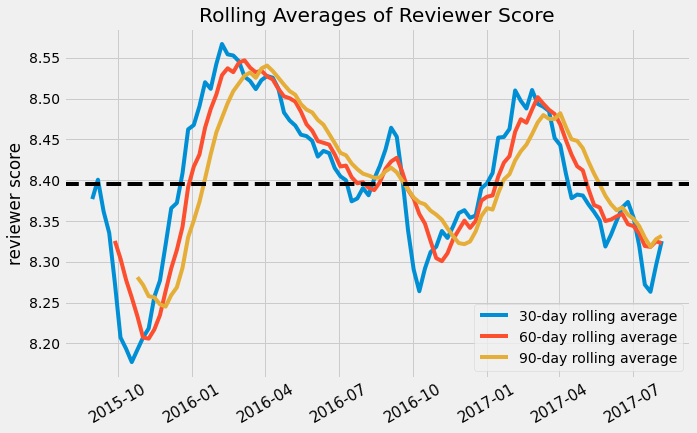

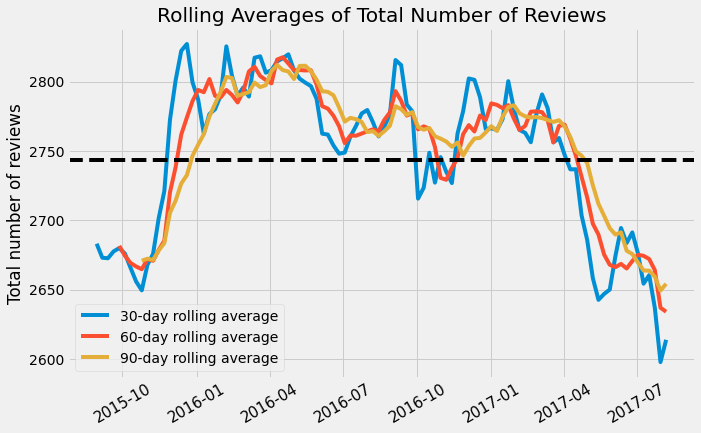

In [9]:
hotel_data()

In [10]:
# average number of hotel reviews
print(f'Average Number of Hotel Reviews: {round(df.total_number_of_reviews.mean(),0)}')


Average Number of Hotel Reviews: 2744.0


Key Takeaways:

The data shows that between July to December(end of the year/Holiday season) guest tend to score hotels lower then average. Where between January to June guest tend to score hotels higher then average. There is a slight decline in customer reviews as the year progresses.

---

### Exploration - Promoter Scores:

- Promoter scores use reviewer's scores between 0 and 10 to classify each reviewer as either a 'promoter' ($score>9$), a 'passive' ($7<score<9$), or a 'detractor' ($score<7$).

- The promoter score for a hotel is calculated by taking the number of promoters minus the number of detractors divided by the total number of reviewers

In [11]:
def hotel_nps_score(series):
    '''
    This function takes in a series from the nps_group column and calculates the promoter score by
    taking the count of promoters minus the count of detractors and dividing it by the total number
    of reviewers
    '''
    score = ((series == 'promoter').sum() - (series == 'detractor').sum()) / series.size
    score = round(score * 100)
    return score

In [12]:
#calculate promoter scores for each hotel
hotel_df = pd.DataFrame(df.groupby(df.hotel_name).nps_group.apply(hotel_nps_score))
#rename the resulting score column as 'promoter score'
hotel_df = hotel_df.rename(columns={'nps_group':'promoter_score'})
#sort the values in decending order and show the truncated results
hotel_df.sort_values(by='promoter_score', ascending=False)

,promoter_score
hotel_name,
H10 Casa Mimosa 4 Sup,93
Ritz Paris,93
Hotel Casa Camper,93
The Soho Hotel,92
Bulgari Hotel London,92
...,...
Villa Eugenie,-52
Kube Hotel Ice Bar,-53
Savoy Hotel Amsterdam,-56


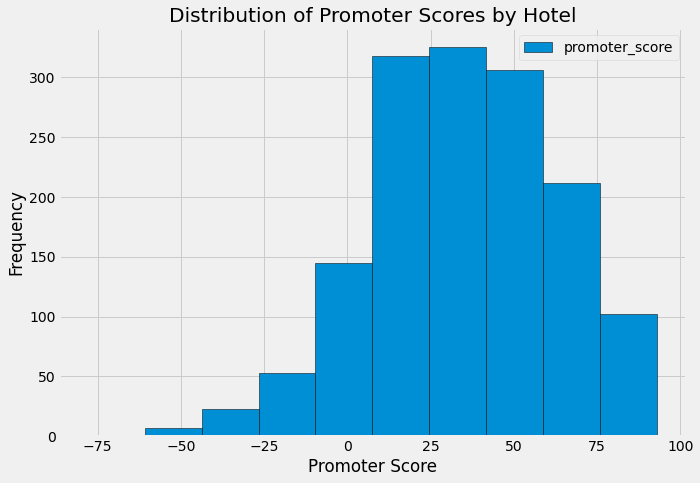

In [13]:
#Distribution of hotel promoter scores
hotel_df.plot.hist(ec='black')
plt.title('Distribution of Promoter Scores by Hotel')
plt.xlabel('Promoter Score')
plt.show()

Key Takeaways:

The average promoter score is 34.
The minimum promoter score is -78.
The maximum promoter score is 93. 

The promoter score is a method we used to determine the hotel's overall performance. The higher the score, the better the hotel performed with an accuracy better than just the average score. The lower the score, the worse the hotel performed overall.

In [14]:
# average promoter score in hotel_df
hotel_df.promoter_score.describe()

count    1492.000000
mean       34.391421
std        27.524849
min       -78.000000
25%        16.000000
50%        35.000000
75%        55.000000
max        93.000000
Name: promoter_score, dtype: float64

---

## Exploration - Natural Language Processing

- After cleaning / wrangling the text data from the reviews we looked at most frequent unigrams, bigrams, trigram, etc from both the positive reviews and the negative reviews. 

In [15]:
#join all the positive review text into one string
pos_reviews = ' '.join(df.positive_clean_review)
#split the string on whitespaces so word count/comparisons can be made
pos_reviews = pos_reviews.split()
#join all the negative review text into one string
neg_reviews = ' '.join(df.negative_clean_review) 
#split the string on whitespaces so word count/comparisons can be made
neg_reviews = neg_reviews.split()

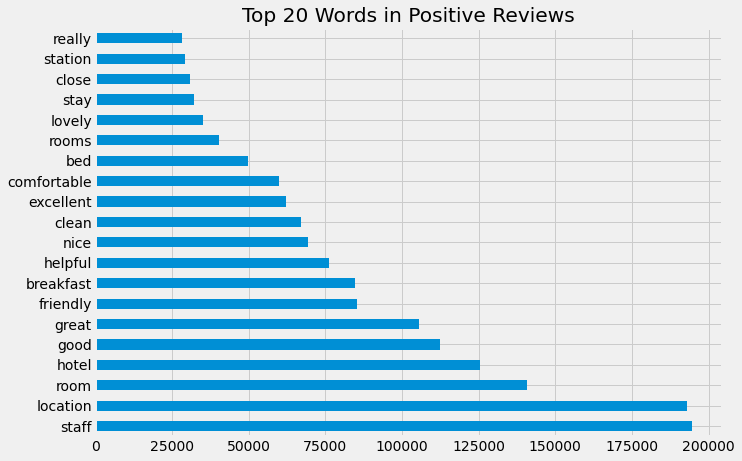

In [16]:
#visualize the top 20 unigrams in the positive reviews
pd.Series(pos_reviews).value_counts().head(20).plot.barh()
plt.title('Top 20 Words in Positive Reviews')
plt.show()

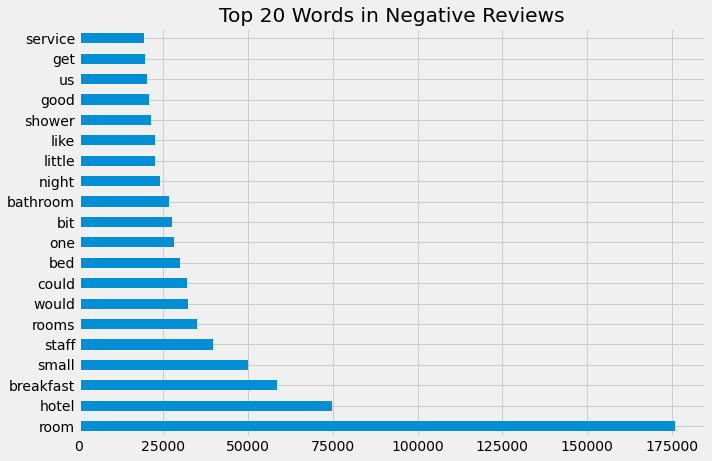

In [17]:
#visualize the top 20 words in the negative reviews
pd.Series(neg_reviews).value_counts().head(20).plot.barh()
plt.title('Top 20 Words in Negative Reviews')
plt.show()

Text(0.5, 1.0, 'Top 20 Bigrams in Positive Reviews')

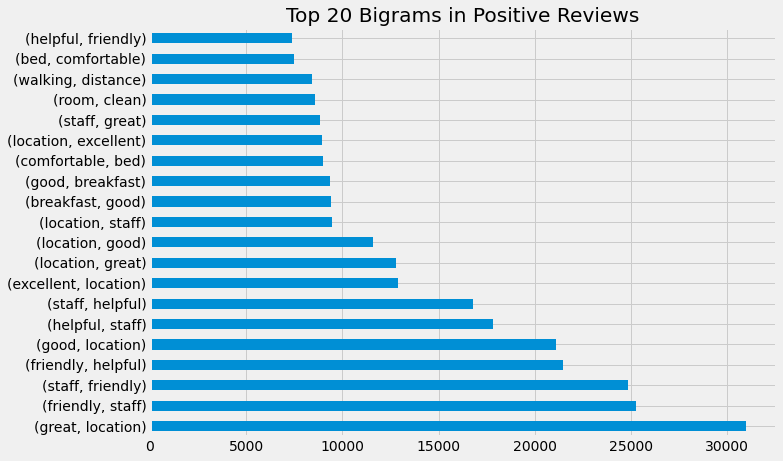

In [18]:
#top 20 positive review bigrams
pos_bigrams = (pd.Series(nltk.ngrams(pos_reviews, 2)).value_counts().head(20))
pos_bigrams.plot.barh()
plt.title('Top 20 Bigrams in Positive Reviews')

Text(0.5, 1.0, 'Top 20 Bigrams in Negative Reviews')

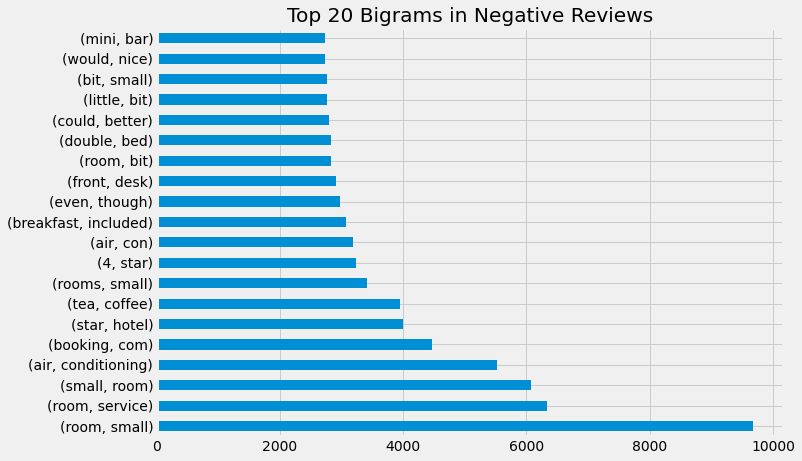

In [19]:
#top 20 negative review bigrams
neg_bigrams = (pd.Series(nltk.ngrams(neg_reviews, 2)).value_counts().head(20))
neg_bigrams.plot.barh()
plt.title('Top 20 Bigrams in Negative Reviews')

Text(0.5, 1.0, 'Top 20 Tetragrams in Positive Reviews')

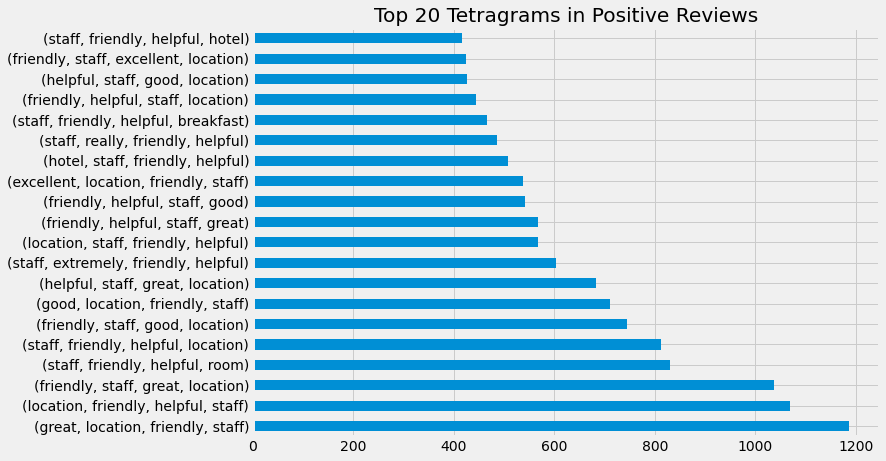

In [20]:
#top 20 positive review n-grams = 4
pos_quadgrams = (pd.Series(nltk.ngrams(pos_reviews, 4)).value_counts().head(20))
pos_quadgrams.plot.barh()
plt.title('Top 20 Tetragrams in Positive Reviews')

Text(0.5, 1.0, 'Top 20 Tetragrams in Negative Reviews')

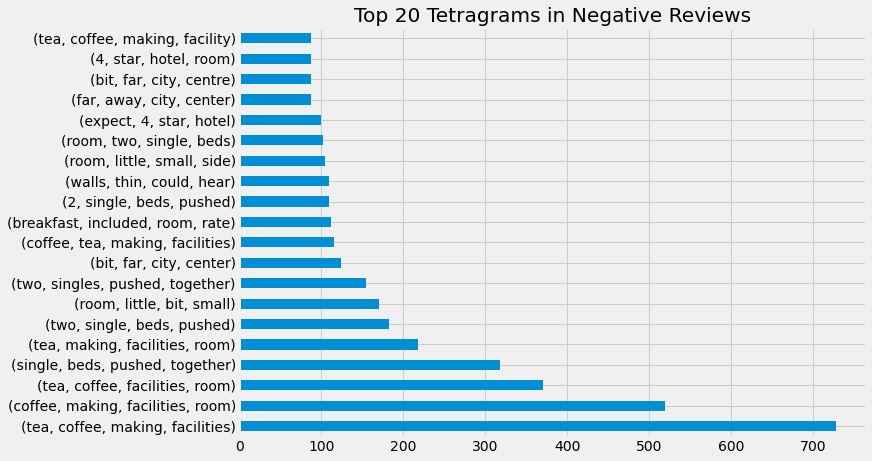

In [21]:
#top 20 negative review n-grams = 4
neg_quadgrams = (pd.Series(nltk.ngrams(neg_reviews, 4)).value_counts().head(20))
neg_quadgrams.plot.barh()
plt.title('Top 20 Tetragrams in Negative Reviews')

---

## Sentiment Intensity Analysis

#### Sentiment Intensity scores are, in essence, calculated by the use of a comparison to a dictionary of positive and negative words. 
The scores range from -1 to 1, -1 being the most negative, and 1 being the most positive.

- Notable trends were found in the average sentiment intensity scores for trip type ('leisure', 'business', 'unknown') and group type ('couple', 'solo traveler', 'group', 'family with young children', 'family with older children', 'travelers with friends').
- Leisure travelers' average sentiment intensity scores were higher than those of the other two trip types.
- Solo travelers and families with young children tended to have lower average sentiment intensity scores than the other groups.
- Sentiment scores for negative reviews were muted in comparison to scores for positive reviews.
- Among the Net Promoter Score groups ('Detractor', 'Passive', 'Promoter'), of note is the 'Passive' group, whose average scores were higher than the other groups on negative reviews.


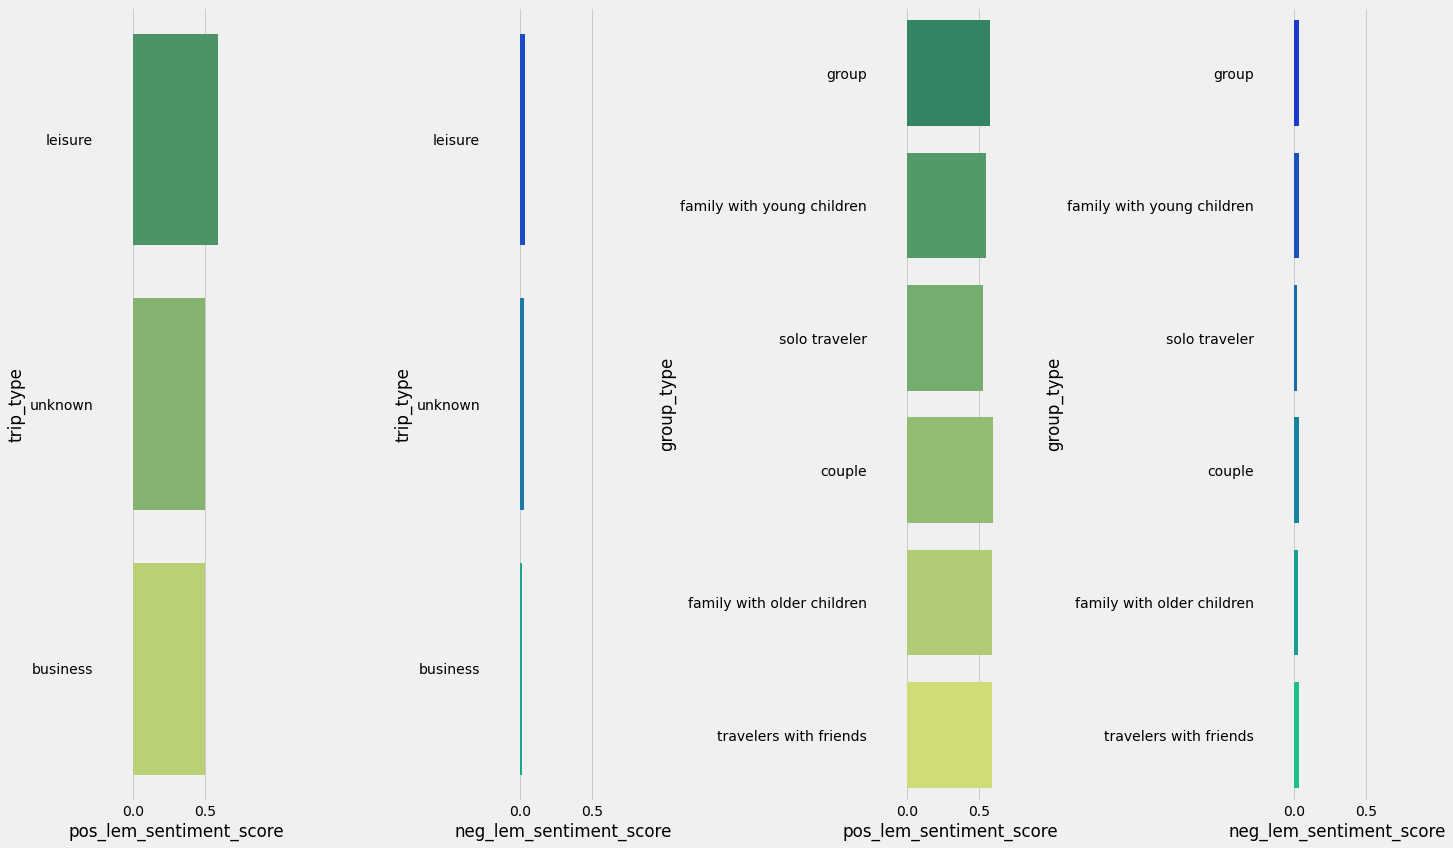

In [22]:
plt.figure(figsize=(20,12))

# Compare trip type and positive sentiment score
plt.subplot(141)
plt.xlim(-.25, .85)
sns.barplot(data=df, y= 'trip_type', x= 'pos_lem_sentiment_score', ci=False, palette='summer')
#plt.show()

# Compare group type and positive sentiment score
plt.subplot(143)
plt.xlim(-.25, .85)
sns.barplot(data=df, y= 'group_type', x= 'pos_lem_sentiment_score', ci= False, palette='summer')

# Compare trip type and negative sentiment score
plt.subplot(142)
plt.xlim(-.25, .85)
sns.barplot(data=df, y= 'trip_type', x= 'neg_lem_sentiment_score', ci=False, palette='winter')

# Compare group type and negative sentiment score
plt.subplot(144)
plt.xlim(-.25, .85)
sns.barplot(data=df, y= 'group_type', x= 'neg_lem_sentiment_score', ci= False, palette='winter')

plt.tight_layout()

<AxesSubplot:xlabel='nps_group', ylabel='neg_lem_sentiment_score'>

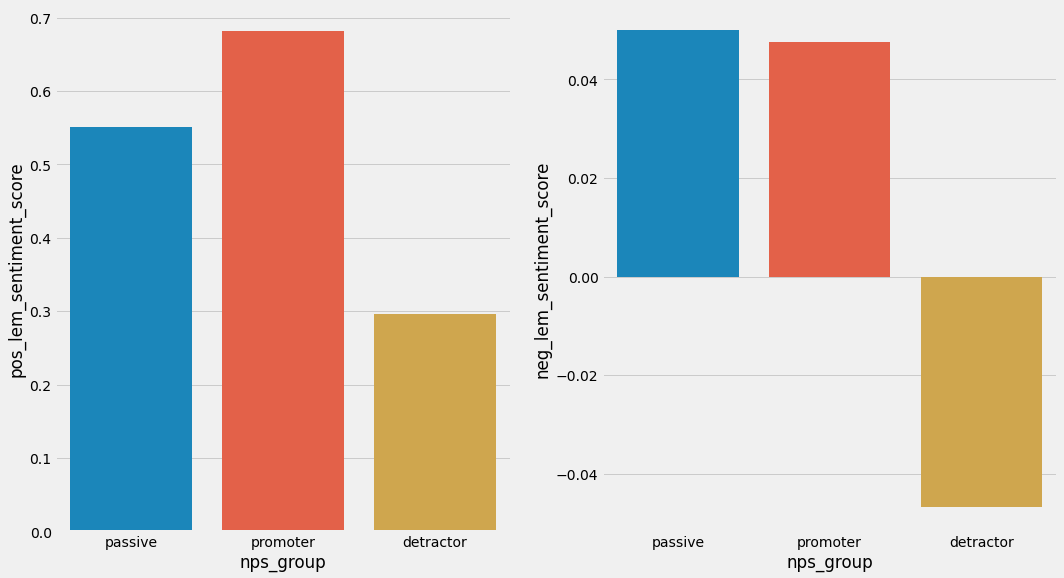

In [23]:
#Compare NPS group and positive sentiment score
plt.figure(figsize=(16,9))

plt.subplot(121)
sns.barplot(data=df, x='nps_group', y='pos_lem_sentiment_score', ci=False)

#Compare NPS group and negative sentiment score
plt.subplot(122)
sns.barplot(data=df, x='nps_group', y='neg_lem_sentiment_score', ci=False)


## Topic Modeling 

- For Topic Modeling we used sklearn's Latent Dirichlet Allocation (LDA) model. The LDA model takes each word in the document and assigns it to one of k topics. k is the number of topics set as a hyperparameter in the creation of the LDA model. The model then calculates the proportion of words in the document that are assigned to each topic or p(topic|document). It then calculates the proportion of documents assigned to each topic because of the words in the document or p(word|topic). 

- Pragmatically our process consisted of using the sklearn Count Vectorizer to produce a sparse matrix of token counts from each collection of positive and negative reviews. This sparse matrix was then used as the input for the LDA model and through some data wrangle of the model output we were able to find the top topic for each document as well as the top 15 words for each topic.

- After completing the topic modeling process the resulting dominant topic values for both the positive and negative reviews were saved as a csv and loaded into the notebook. A new categorical feature column was added to the dataframe that denotes the dominant topic for that review.

- The top 15 key words for each of the 10 topic groups for both the negative and positive reviews can be seen below. These key words are paired with the most frequent dominant topic in the hotel specific dataset seen later in this notebook

### LDA Topic Model findings

- Used as a starting point for manual topic model creation

In [24]:
#read in the positive topic keywords csv
pos_keywords = pd.read_csv('positive_topic_keywords.csv')
pos_keywords

FileNotFoundError: [Errno 2] No such file or directory: 'positive_topic_keywords.csv'

In [ ]:
#read in the negative topic keywords csv
neg_keywords = pd.read_csv('negative_topic_keywords.csv')
neg_keywords

In [ ]:
staff_words = ['staff','friendly','helpful','reception','maids','attentive','concierge','service','receptionist']    
location_words = ['location','located','view','area','metro','city','central','centre','center','train','access','walk',
                      'public','transport','transportation','downtown','accessible','station','convenient','shop','distance']    
room_words = ['room','bed','matress','bathroom','spacious','shower','suite','pillow','bedroom','conditioning','bathtub','air',
                  'window','conditioned','double','twin','size','single','noise','tv','bath','carpet','tile','noisy','small',
                  'furniture','quiet','toilet']    
facilities_words = ['facilities','breakfast','security','buffet','restaurant','bar','coffee','tea','pool','wifi','facility',
                        'parking','lobby','lounge','drink','hall','corridor','menu','storage','order','dining']   
value_words = ['value','money','cheap','cheapest','expensive','price','priced','cost']    
hotel_words = ['hotel']    
comfort_words = ['comfort','nothing','everything','atmosphere','good','comfortable','uncomfortable','pretty','clean','experience']

manual_topics = pd.DataFrame()
topics = ['Staff','Locations','Room','Facilities','Value','Hotel','Comfort']
lists = [staff_words,location_words,room_words,facilities_words,value_words,hotel_words,comfort_words]
manual_topics['Topics'] = topics
manual_topics['Words'] = lists
manual_topics

---

## Exploration of Drivers of Reviewer Score by Key Customer Group

#### Group Type = Couples:

- The majority of group type represented in this dataset was couples. Breakdown of dominant topics and keywords for this subgroup is seen below

In [ ]:
#subset the dataframe to represent only reviews from group types that were couples
couples = df[df['group_type'] == 'couple']
#view the counts based on nps group
couples.nps_group.value_counts()

In [ ]:
#further subset the dataframe by the observations that were couples and detractors
detractor_couples = couples[couples['nps_group'] == 'detractor']
#show the top three negative dominant topics
detractor_couples.negative_topic.value_counts()

In [ ]:
#further subset the dataframe by the observations that were couples and detractors
promoter_couples = couples[couples['nps_group'] == 'promoter']
#show the top three negative dominant topics
promoter_couples.positive_topic.value_counts()

#### Key Findings:
   - 128840 couples provided a reviewer score of 9 or 10 making them a promoter

   - 37,000 couples provided a reviewer score of less than 7 making them a detractor
   
   - The top three positive review topics were staff, location, and room 
   
   - The top three negative review topics were issues with room, staff, or facilities

---

#### Trip Type = Leisure Trip:

- The majority of trip type represented in this dataset was leisure trips. Breakdown of dominant topics and keywords for this subgroup is seen below

In [ ]:
leisure_trip = df[df['trip_type'] == 'leisure']
leisure_trip.nps_group.value_counts()

In [ ]:
detractor_leisure = leisure_trip[leisure_trip['nps_group'] == 'detractor']
detractor_leisure.negative_topic.value_counts()

In [ ]:
promoter_leisure = leisure_trip[leisure_trip['nps_group'] == 'promoter']
promoter_leisure.positive_topic.value_counts()

#### Key Findings:
   - 209906 leisure trip customers provided a reviewer score of 9 or 10 making them a promoter

   - 63,492 leisure trip customers provided a reviewer score of less than 7 making them a detractor
   
   - The top three positive review topics were staff, location, and room
   
   - The top three negative review topics were issues with room, staff, or facilities
   

---

#### Nights Stayed = 3 or less

- Most customers in this dataset stayed four or less nights

In [ ]:
threel_night = df[df['nights_stayed'] <= 3]
threel_night.nps_group.value_counts()

In [ ]:
threel_detractor = threel_night[threel_night['nps_group'] == 'detractor']
threel_detractor.negative_topic.value_counts()

In [ ]:
threel_promoter = threel_night[threel_night['nps_group'] == 'promoter']
threel_promoter.positive_topic.value_counts()

#### Key Findings:

- 204510 customers who stayed three or less nights provided a reviewer score greater than 9 making them a promoter

- 71222 customers who stayed three or less nights provided a reviewer score of less than 7 making them a detractor

- The top three positive review topics were staff, location, and room

- The top three negative review topics were issues with room, staff, or facilities

In [ ]:
pos = pd.DataFrame()
pos['topics'] = promoter_couples.positive_topic.value_counts().sort_index().index
pos['couples'] = promoter_couples.positive_topic.value_counts().sort_index().values
pos['leisure_trip'] = promoter_leisure.positive_topic.value_counts().sort_index().values
pos['three_or_less'] = threel_promoter.positive_topic.value_counts().sort_index().values
pos = pos.set_index('topics')
pos

In [ ]:
pos.plot.bar()
plt.title('Positive Review Topics vs. Largest Customer Subgroups')

In [ ]:
neg = pd.DataFrame()
neg['topics'] = detractor_couples.negative_topic.value_counts().sort_index().index
neg['couples'] = detractor_couples.negative_topic.value_counts().sort_index().values
neg['leisure_trip'] = detractor_leisure.negative_topic.value_counts().sort_index().values
neg['three_or_less'] = threel_detractor.negative_topic.value_counts().head(9).sort_index().values
neg = neg.set_index('topics')
neg

In [ ]:
neg.plot.bar()
plt.title('Negative Review Topics vs. Largest Customer Subgroups')

---

### Summary

- Our Primary customer groups include couples, customers on leisure trips, and the majority of our customers stay with us for three or less nights

- The average reviewer score by hotel was 8.47 with a scoring range of 5.12 to 9.73

- reviewer scores showed some seasonality with higher scores in the first half of the year (Jan - Jun) and lower scores in the second half of the year (July - dec)

- When grouping reviewer's scores we found that 48% of our customers were promoters scoring their stay with a 9 or 10 and 17% of our customers were detractors scoring their stay as less than 7

- When aggregating the score groups following a NPS style rating system we found that the average promoter score for our partner hotels was 34 with a range of -78 to 93

- Natural language processing methods were used to identify high frequency words, primary topics and overall sentiment for both positive and negative feedback the customers gave in their reviews

- The top three positive topics in reviews from our key customer groups included staff, location, and rooms

- The top three negative topics in reviews from our key customer groups included a prominent focus on issues with the room followed by issues with the staff and the facilities

- *** Summary of sentiment analysis in one sentence

- The findings from our analysis has been summarized and loaded into a dashboard where each individual hotel can view their specific statistics as well as the statistics from their neighboring hotels for comparison

---

### Next Steps

- SHAP sentiment analysis
- Further exploration of manual topic assignment
- Optimize Topic Model hyperparameters
- Number of Topics
- Unigrams, Bigrams, Trigrams
- Different topic modeling algorithms:
- Truncated SVD/Latent Semantic Analysis
- Non-negative Matrix Factorization
- TF-IDF Vectorizer